In [1]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def extract_features(file_path):
    try:
        audio_data, _ = librosa.load(file_path, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio_data, sr=22050, n_mfcc=13)
        return np.mean(mfccs.T, axis=0)
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        return None

In [3]:
def load_data(folder_path):
    data = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.mp3'):
            file_path = os.path.join(folder_path, filename)
            
            language = filename.split('_')[2]
            
            features = extract_features(file_path)
            if features is not None:
                data.append(features)
                labels.append(language)
    
    return np.array(data), np.array(labels)

In [4]:
audio_folder = '/home/basil3325/languages'

In [5]:
X, y = load_data(audio_folder)

In [6]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [20]:
svm_classifier = SVC(probability=True)
svm_classifier.fit(X_train, y_train)

gb_classifier = GradientBoostingClassifier()
gb_classifier.fit(X_train, y_train)

voting_classifier = VotingClassifier(estimators=[
    ('svm', svm_classifier),
    ('gb', gb_classifier)
], voting='soft') 

voting_classifier.fit(X_train, y_train)

VotingClassifier(estimators=[('svm', SVC(probability=True)),
                             ('gb', GradientBoostingClassifier())],
                 voting='soft')

In [27]:
y_pred = voting_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 77.67%


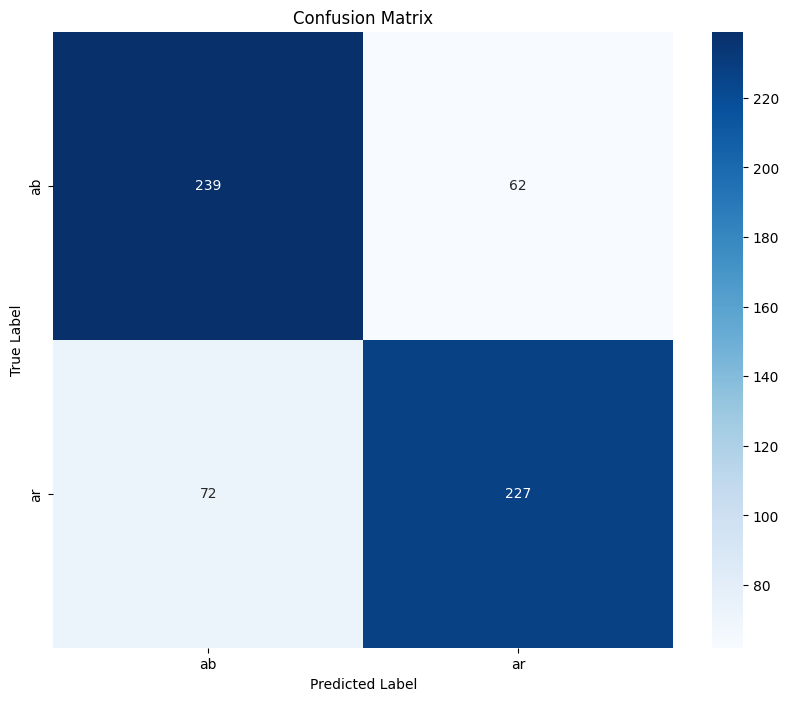

In [22]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [23]:
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Classification Report:
               precision    recall  f1-score   support

          ab       0.77      0.79      0.78       301
          ar       0.79      0.76      0.77       299

    accuracy                           0.78       600
   macro avg       0.78      0.78      0.78       600
weighted avg       0.78      0.78      0.78       600



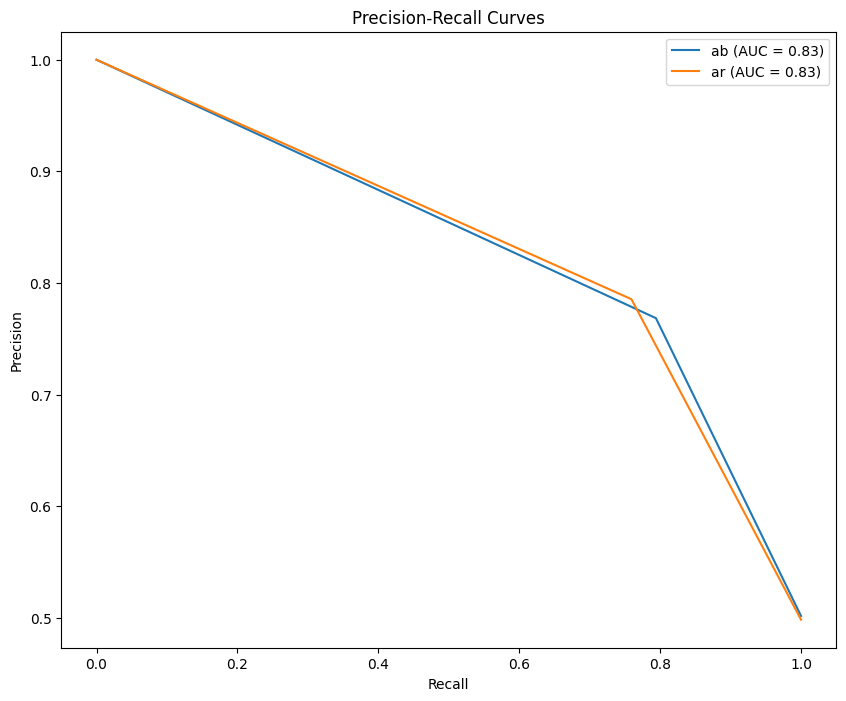

In [24]:
plt.figure(figsize=(10, 8))
for i, label in enumerate(label_encoder.classes_):
    precision, recall, _ = precision_recall_curve(y_test == label_encoder.transform([label]), y_pred == label_encoder.transform([label]))
    area = auc(recall, precision)
    plt.plot(recall, precision, label=f'{label} (AUC = {area:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.show()

/tmp/ipykernel_6493/2736260141.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_encoder.classes_, y=class_accuracy, palette='viridis')


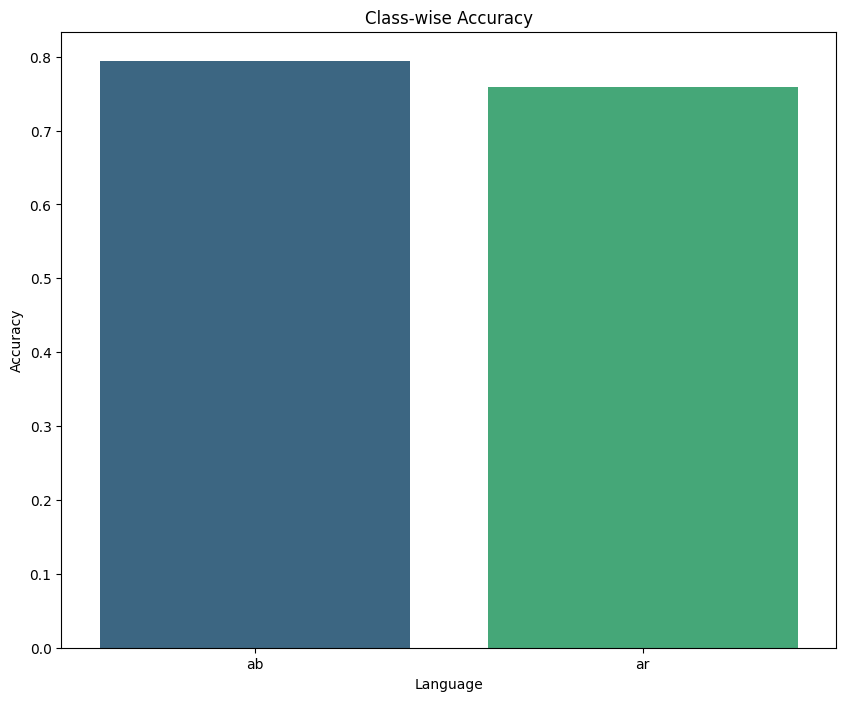

In [25]:
class_accuracy = [accuracy_score(y_test[y_test == label_encoder.transform([label])], y_pred[y_test == label_encoder.transform([label])]) for label in label_encoder.classes_]

plt.figure(figsize=(10, 8))
sns.barplot(x=label_encoder.classes_, y=class_accuracy, palette='viridis')
plt.xlabel('Language')
plt.ylabel('Accuracy')
plt.title('Class-wise Accuracy')
plt.show()
